# IEEE-CIS Fraud Detection


## Setup

In [56]:
import pandas as pd 


In [59]:
MODEL_ID=0


In [57]:
DATA_PATH = "data"
VERBOSE = True 
R_S = 42
VAL_SIZE = 0.2

In [58]:
train_transaction = pd.read_csv(f"{DATA_PATH}/train_transaction.csv")
train_identity = pd.read_csv(f"{DATA_PATH}/train_identity.csv")

test_transaction = pd.read_csv(f"{DATA_PATH}/test_transaction.csv")
test_identity = pd.read_csv(f"{DATA_PATH}/test_identity.csv")

print(train_transaction.shape)
print(train_identity.shape)

(590540, 394)
(144233, 41)


## 1. Exploratory Data Analysis


### 1.1 Data description (Kaggle) 
The data is broken into two files `identity` and `transaction`, which are joined by `TransactionID`. **TODO: Not all transactions have corresponding identity information.**

**Categorical Features - Transaction**
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**
- DeviceType
- DeviceInfo
- id_12 - id_38

The `TransactionDT` feature is a timedelta from a given reference datetime (not an actual timestamp).

**Files**
- train_{transaction, identity}.csv - the training set
- test_{transaction, identity}.csv - the test set 
- sample_submission.csv - a sample submission file in the correct format

The goal is to predict the isFraud value for these observation. 

### 1.2 Data interpretation: 
1. General discussion:  https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203 
2. Lynn@Vesta interpretation: 

**Transaction table**:
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp).  
(Tudor Lapusant interpretation: Timedelta from a given reference datetime (not an actual timestamp) **“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”**
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
- Categorical Features: ProductCD card1 - card6 addr1, addr2 P_emaildomain R_emaildomain M1 - M9.  

**Identity table**: 
Variables in this table are: 
- identity information – network connection information (IP, ISP, Proxy, etc) 
- digital signature (UA/browser/os/version, etc) associated with transactions.  
They're collected by Vesta’s fraud protection system and digital security partners. (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)
- Categorical Features: DeviceType DeviceInfo id_12 - id_38. 







In [16]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#train_transaction.isna().mean().sort_values(ascending=False)

In [18]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [19]:
#train_identity.isna().mean().sort_values(ascending=False)

In [20]:
# Merge the transaction, identity tables
# left join because: "Not all transactions have corresponding identity information."

train_df = train_transaction.merge(
    train_identity,
    on="TransactionID",
    how="left"
)

X_test = test_transaction.merge(
    test_identity,
    on="TransactionID",
    how="left"
)


In [21]:
y = train_df["isFraud"]
X = train_df.drop(columns=["isFraud"])

In [22]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.9+ GB


In [12]:
y.value_counts(normalize=True)


isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=VAL_SIZE,
    random_state=R_S,
    stratify=y
)


### 1.3 Missing rate 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
missing_rate = train_df.isna().mean()
missing_rate

TransactionID     0.000000
isFraud           0.000000
TransactionDT     0.000000
TransactionAmt    0.000000
ProductCD         0.000000
                    ...   
id_36             0.761261
id_37             0.761261
id_38             0.761261
DeviceType        0.761557
DeviceInfo        0.799055
Length: 434, dtype: float64

In [25]:
n_features = len(missing_rate)

n_ge_75 = (missing_rate >= 0.75).sum()
n_ge_85 = (missing_rate >= 0.85).sum()

print(f"Total features: {n_features}")
print(f"Features with missing rate >= 0.75: {n_ge_75} ({n_ge_75 / n_features:.1%})")
print(f"Features with missing rate >= 0.85: {n_ge_85} ({n_ge_85 / n_features:.1%})")


Total features: 434
Features with missing rate >= 0.75: 208 (47.9%)
Features with missing rate >= 0.85: 74 (17.1%)


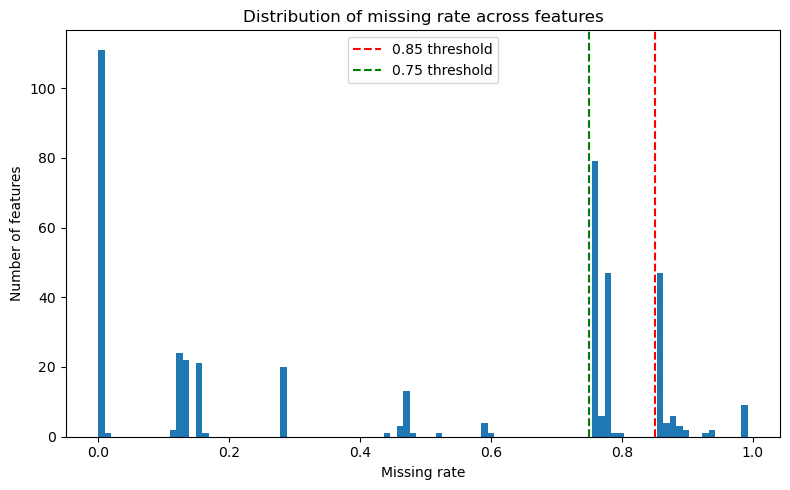

In [34]:
plt.figure(figsize=(8, 5))
plt.hist(missing_rate, bins=100)
plt.axvline(0.85, c='r', linestyle="--", label="0.85 threshold")
plt.axvline(0.75, c='g', linestyle="--", label="0.75 threshold")

plt.xlabel("Missing rate")
plt.ylabel("Number of features")
plt.title("Distribution of missing rate across features")
plt.legend()
plt.tight_layout()
plt.show()


### 1.4 Categorical variables

## 2. Data preprocessing

In [35]:
def preprocess_data(df):
    return df

### 2.1 Missing data handling

#### Missing data patterns 
TODO

### Feature engineering 

## 3. Models 

### 3.1 Baseline 
The data preprocessing functions defined above are not utalized by the baseline models. Instead we use simple strategies:   
a) drop all categorical data,  drop numerical data where missing threshold $\ge$ missing_thresh, data imputation: median   
b) numerical variables as above, but we drop categorical variables with $\geq$ 250 unique values and then use one-hot (in practise, only 'DeviceInfo' with ~2000 unique values will be deleted).    

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import roc_auc_score, average_precision_score

import time
import joblib
from datetime import datetime

In [47]:
model_results = []

In [ ]:
X_train_num = X_train.select_dtypes(include=["number"]).copy()
X_val_num   = X_val.select_dtypes(include=["number"]).copy()

if "TransactionID" in X_train_num.columns:
    X_train_num.drop(columns=["TransactionID"], inplace=True)
    X_val_num.drop(columns=["TransactionID"], inplace=True)

missing_rate = X_train_num.isna().mean()

def baseline_a(missing_thresh=0.9, max_iter=1000, class_weight="balanced",
               solver="saga",C=1.0,penalty="l2"):
    global MODEL_ID

    keep = missing_rate[missing_rate <= missing_thresh].index
    X_train_num_pruned = X_train_num[keep]
    X_val_num_pruned = X_val_num[keep]

    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()), # diff comparing to the version we sent in the first report 
        ("clf", LogisticRegression(max_iter=max_iter, 
                                   solver=solver, 
                                   C=C,  
                                   class_weight=class_weight, 
                                   penalty=penalty,
                                   verbose=VERBOSE))
    ])

    start_time = time.time() 
    pipe.fit(X_train_num_pruned, y_train)
    end_time = time.time()   
    duration = end_time - start_time

    proba = pipe.predict_proba(X_val_num_pruned)[:, 1]

    roc = roc_auc_score(y_val, proba)
    prauc = average_precision_score(y_val, proba)
    print("model {id} results: ")
    print("ROC-AUC:",roc)
    print("PR-AUC:", prauc)

    path = f"baseline_{MODEL_ID}.pkl"
    joblib.dump(pipe, path)

    model_info = {
        "id": MODEL_ID,
        "model": "baseline_with_scaler", 
        "ROC": roc,
        "PR_AUC": prauc,
        "thresh": missing_thresh,
        "C": C,
        "max_iter": max_iter,
        "time": round(duration/60, 2),
        "path": path
    }
    MODEL_ID+=1

    model_results.append(model_info)

In [ ]:
for max_iter in [5000,10000]:
    for C in [0.01, 0.1, 1]:
        baseline_a(missing_thresh=0.9, max_iter=max_iter, C=C,  solver="lbfgs")

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.0s finished


ROC-AUC: 0.8540308847937044
PR-AUC: 0.4157357703050368


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.0s finished


ROC-AUC: 0.854984583396113
PR-AUC: 0.42042929049359523


In [ ]:
for max_iter in [5000,10000]:
    for C in [0.01, 0.1, 1]:
        baseline_a(missing_thresh=0.9, max_iter=max_iter, C=C,  
                   solver="saga",
                   penalty="l1")